# HABSlib 104
In this fourth notebook, we will learn how to assess the quality of the BrainOS APIs for feature extraction.

### What is Quality Assessment
Quality assessment is the data collection and analysis process, which measures the degree of conformity to predetermined standards and criteria ([NIH Medicare](https://www.ncbi.nlm.nih.gov/books/NBK235459/)).

### How we do it
For this session, we will use the HABSlib EEG simulator to have an EEG signal of known frequency content and noise. Then we will use the BrainOS API to analyze such content.      
In particular, we will compare two EEG simulations to measure how noise affects the BrainOS ability to extract a known amplitude alpha content.
    
Please, refer to the documentation of [HABSlib](https://olocufier.github.io/HABSlib/) for further details.

In [1]:
import nest_asyncio # to allow HABSlib to run async in a Jupyter notebook
nest_asyncio.apply()

import HABSlib as hb
from datetime import datetime
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt


/Users/do/neuromodulation/nm/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## Login
In order to use the HABS API, you need to create a free account on habs.ai/developer.    
This provides you with the **developer IP address** you can use, and a **user ID**, which you will use for all your interaction with the APIs.

The first thing to do to start a session with the HABS BrainOS is to handshake.

In [2]:
hb.handshake(base_url="http://0.0.0.0", user_id='8d60e8693a9560ee57e8eba3')


       HUMAN        AUGMENTED        BRAIN         SYSTEMS     
   ----------------------------------------------------------- 
   ▒▒▒▒     ▒▒▒▒     ░▒▒▒▒▒░     ▒▒▒▒▒▒▒▒▒▒▒▒░   ░▒▒▒▒▒▒▒▒▒░   
   ▒▒▒▒     ▒▒▒▒    ░▒▒▒▒▒▒▒░             ░▒▒▒▒ ░▒▒▒░     ░▒░  
   ▒▒▒▒▒▒▒▒▒▒▒▒▒   ░▒▒▒▒ ▒▒▒▒░   ▒▒▒▒▒▒▒▒▒▒▒▒▒   ░▒▒▒▒▒▒▒▒▒░   
   ▒▒▒▒     ▒▒▒▒  ░▒▒▒▒   ▒▒▒▒░  ▒▒▒▒     ░▒▒▒▒ ░▒░     ░▒▒▒░  
   ▒▒▒▒     ▒▒▒▒ ░▒▒▒▒     ▒▒▒▒░ ▒▒▒▒▒▒▒▒▒▒▒▒░   ░▒▒▒▒▒▒▒▒▒░   
   ----------------------------------------------------------- 
   version: 0.1.38

Handshake (RSA) successful.
Handshake (AES) successful.


True

## Synthetic data with no noise
First, we look at the simulated EEG with no added noise and a high beta content.

In [3]:
# Acquire synthetic EEG data with the current noise and beta amplitude
session_no_noise_id = hb.acquire_send_raw(
    user_id='8d60e8693a9560ee57e8eba3', 
    date=datetime.today().strftime('%Y-%m-%d %H:%M:%S'), 
    board="SYNTHETIC", 
    extra={
        "eeg_channels": 16,
        "sampling_rate": 250,
        "noise": 0,           # noise amplitude
        "artifacts": 0.0,       # probability of having a movement/blink artifact in the recording
        "beta_amp": 15,          # beta amplitude
        "modulation_type": 'random',
        "power_law_slope": 1.0
    },
    serial_number="", 
    stream_duration=20, 
    buffer_duration=5
)

Session successfully created.

Session initialized. You can visualize it here:
  https://habs.ai/live.html?session_id=66b767ae3206b3bb86070558 

{'user_id': '8d60e8693a9560ee57e8eba3', 'session_date': '2024-08-10 15:14:22', 'session_type': '', 'session_tags': []}
Metadata validation successful!
Connecting to the headset...
Headset connected successfully!
....
Stopping data streaming...
Releasing session...


In [4]:
# Retrieve the data for the session
print(session_no_noise_id)
results_zero = hb.get_data_by_session(user_id='8d60e8693a9560ee57e8eba3', session_id=session_no_noise_id)
eeg_data_zero = np.array(results_zero)
print(np.mean(eeg_data_zero))

66b767ae3206b3bb86070558
Retrieved data successfully.
12.204288195568592


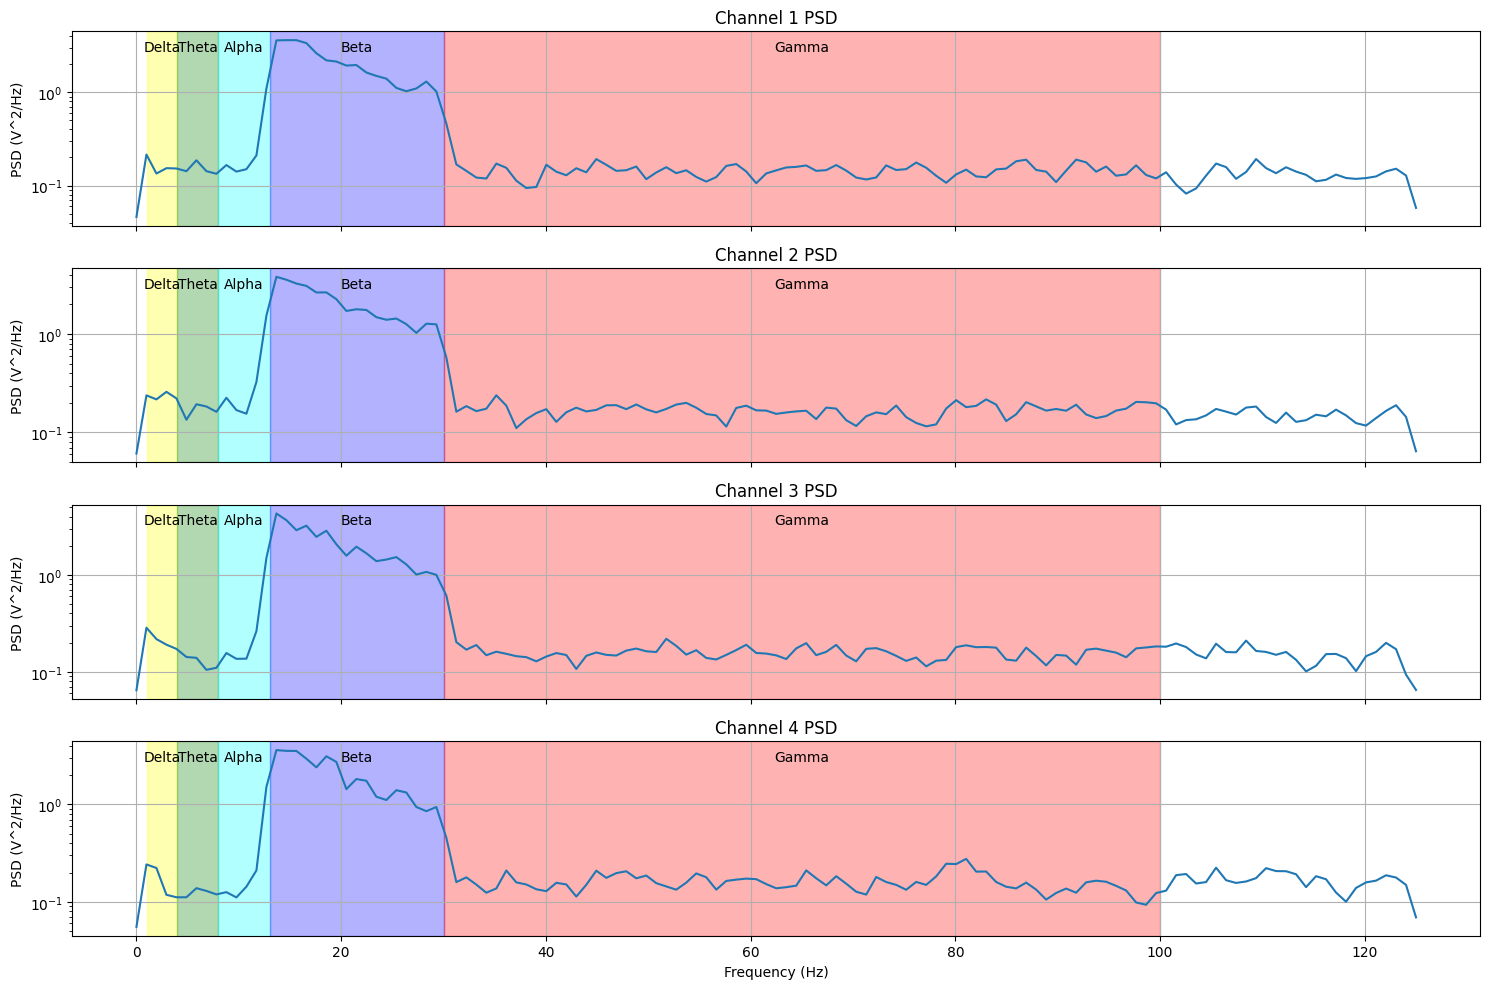

In [5]:
from scipy import signal

samples_per_second = 250
num_channels=4 # how many you want to plot

# Define frequency bands
bands = {
    'Delta': (1, 4, 'yellow'),
    'Theta': (4, 8, 'green'),
    'Alpha': (8, 13, 'cyan'),
    'Beta': (13, 30, 'blue'),
    'Gamma': (30, 100, 'red')
}

fig, axes = plt.subplots(num_channels, 1, figsize=(15, 10), sharex=True)

if num_channels == 1:
    axes = [axes]

for i in range(num_channels):
    # Plotting the PSD
    freqs, psd = signal.welch(eeg_data_zero[i], fs=samples_per_second)
    axes[i].semilogy(freqs, psd)
    axes[i].set_title(f'Channel {i+1} PSD')
    axes[i].set_ylabel('PSD (V^2/Hz)')
    axes[i].grid(True)

    # Highlighting frequency bands
    for band, (low, high,col) in bands.items():
        axes[i].axvspan(low, high, color=col, alpha=0.3)
        axes[i].text((low + high) / 2, max(psd), band, horizontalalignment='center', verticalalignment='top')

axes[-1].set_xlabel('Frequency (Hz)')
plt.tight_layout()
plt.show()

## Synthetic data with noise
Then, we look at the simulated EEG with high Beta content and high noise too.

In [6]:
extra_noise = {
    "eeg_channels": 16,
    "sampling_rate": 250,
    "noise": 10,           # noise amplitude
    "beta_amp": 15,         # beta amplitude
    "artifacts": 0.0,
    "modulation_type": 'random',
    "power_law_slope": 1.0
}

# Acquire synthetic EEG data with the current noise and beta amplitude
session_noise_id = hb.acquire_send_raw(
    user_id='8d60e8693a9560ee57e8eba3', 
    date=datetime.today().strftime('%Y-%m-%d %H:%M:%S'), 
    board="SYNTHETIC", 
    extra=extra_noise,
    serial_number="", 
    stream_duration=20, 
    buffer_duration=5
)

Session successfully created.

Session initialized. You can visualize it here:
  https://habs.ai/live.html?session_id=66b767d13206b3bb86070565 

{'user_id': '8d60e8693a9560ee57e8eba3', 'session_date': '2024-08-10 15:14:57', 'session_type': '', 'session_tags': []}
Metadata validation successful!
Connecting to the headset...
Headset connected successfully!
....
Stopping data streaming...
Releasing session...


In [7]:
# Retrieve the data for the session
print(session_noise_id)
results_noise = hb.get_data_by_session(user_id='8d60e8693a9560ee57e8eba3', session_id=session_noise_id)
eeg_data_noise = np.array(results_noise)
print(np.mean(eeg_data_noise))

66b767d13206b3bb86070565
Retrieved data successfully.
12.0136029095373


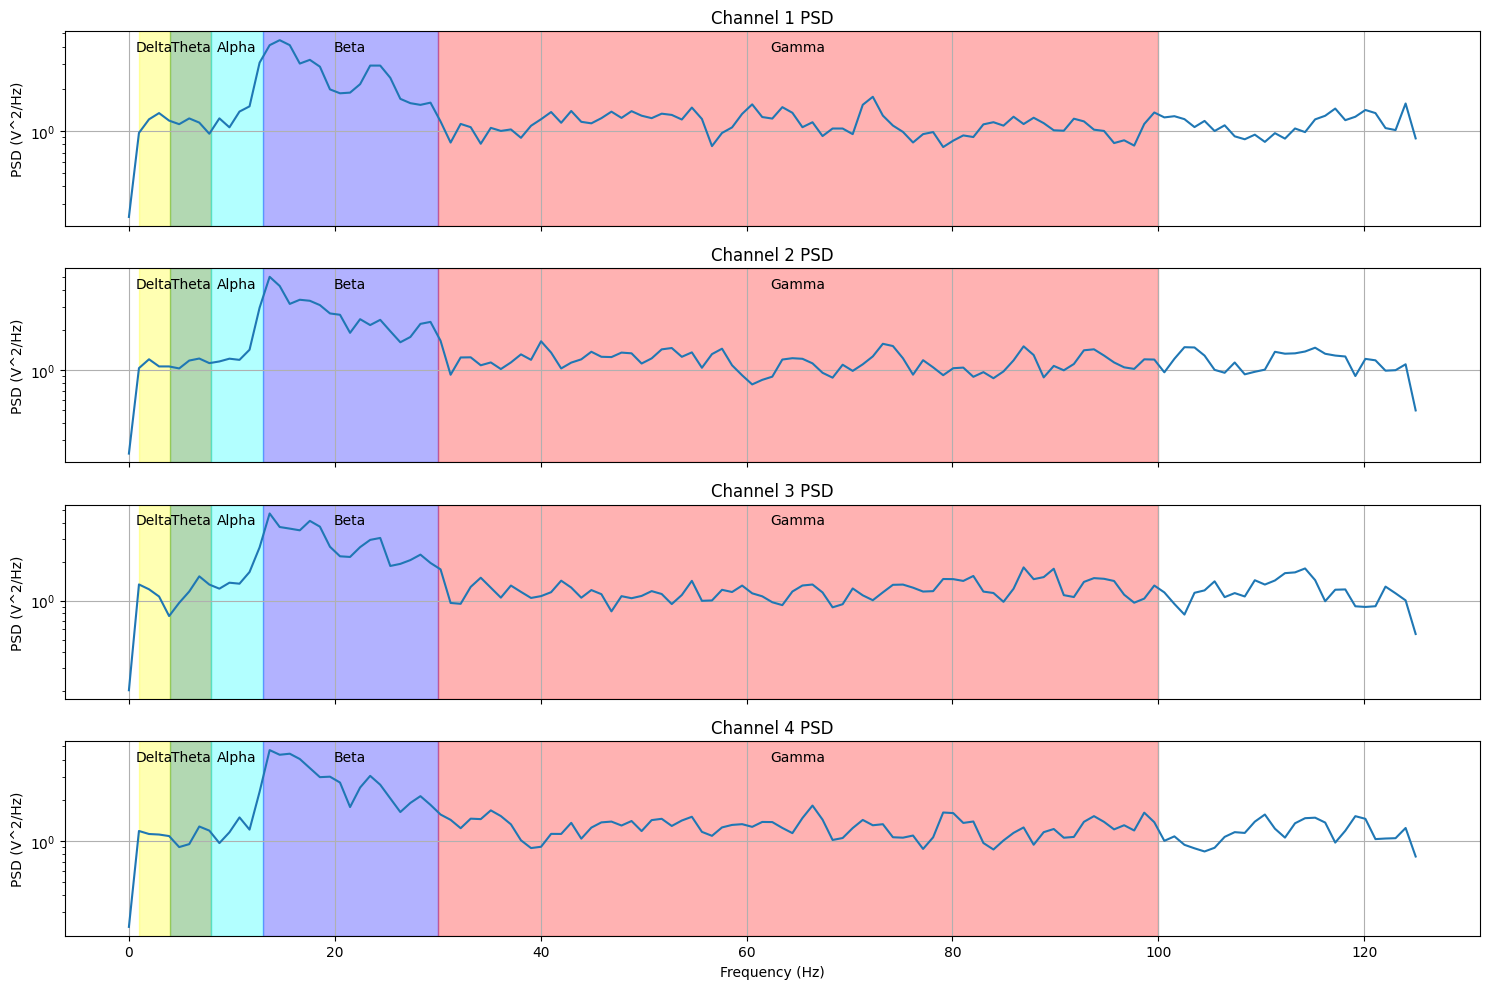

In [8]:
samples_per_second = 250
num_channels=4 # how many you want to plot

# Define frequency bands
bands = {
    'Delta': (1, 4, 'yellow'),
    'Theta': (4, 8, 'green'),
    'Alpha': (8, 13, 'cyan'),
    'Beta': (13, 30, 'blue'),
    'Gamma': (30, 100, 'red')
}

fig2, axes2 = plt.subplots(num_channels, 1, figsize=(15, 10), sharex=True)

for i in range(num_channels):
    # Plotting the PSD
    freqs, psd2 = signal.welch(eeg_data_noise[i], fs=samples_per_second)
    axes2[i].semilogy(freqs, psd2)
    axes2[i].set_title(f'Channel {i+1} PSD')
    axes2[i].set_ylabel('PSD (V^2/Hz)')
    axes2[i].grid(True)
    # Highlighting frequency bands
    for band, (low, high,col) in bands.items():
        axes2[i].axvspan(low, high, color=col, alpha=0.3)
        axes2[i].text((low + high) / 2, max(psd2), band, horizontalalignment='center', verticalalignment='top')

axes2[-1].set_xlabel('Frequency (Hz)')
plt.tight_layout()
plt.show()

## Quality Assessment Strategy
We will generate different dummy EEG signals with known content, to be able to compare the analysis capabilities of the BrainOS API.

We will compare the results of the example API pipeline `/filtering/<band>` for different values of signal (the amplitude of <band> we provide) and noise (also amplitudes we provide).

We automatize this strategy to know exactly which level of band amplitude we can reliably extract with which noise amplitude. In particular, we will change iteratively:
- the noise amplitude (between 0.0 and 0.9)
- the alpha amplitude (between 0 and 10)

We use the synthetic board included in the HABSlib, which allows us to define:
- level of noise ('noise' between 0, no noise, and 1)
- amplitude in each of the frequency bands ('delta_amp', 'theta_amp', ...)



---------------------------
Test 0,0 = noise:0 beta:0

Session successfully created.

Session initialized. You can visualize it here:
  https://habs.ai/live.html?session_id=66b76b523206b3bb8607074d 

{'user_id': '8d60e8693a9560ee57e8eba3', 'session_date': '2024-08-10 15:29:54', 'session_type': '', 'session_tags': []}
Metadata validation successful!
Connecting to the headset...
Headset connected successfully!
....
Stopping data streaming...
Releasing session...
Retrieved data successfully.
{'user_id': '8d60e8693a9560ee57e8eba3', 'session_date': '2024-08-10 15:30:19', 'existing_session_id': '66b76b523206b3bb8607074d', 'session_type': '[On 66b76b523206b3bb8607074d]: Quality Assessment Feature Extraction', 'session_tags': ['beta']}
Metadata validation successful!
Session successfully created.


---------------------------
Test 0,1 = noise:0 beta:1

Session successfully created.

Session initialized. You can visualize it here:
  https://habs.ai/live.html?session_id=66b76b6b3206b3bb8607075

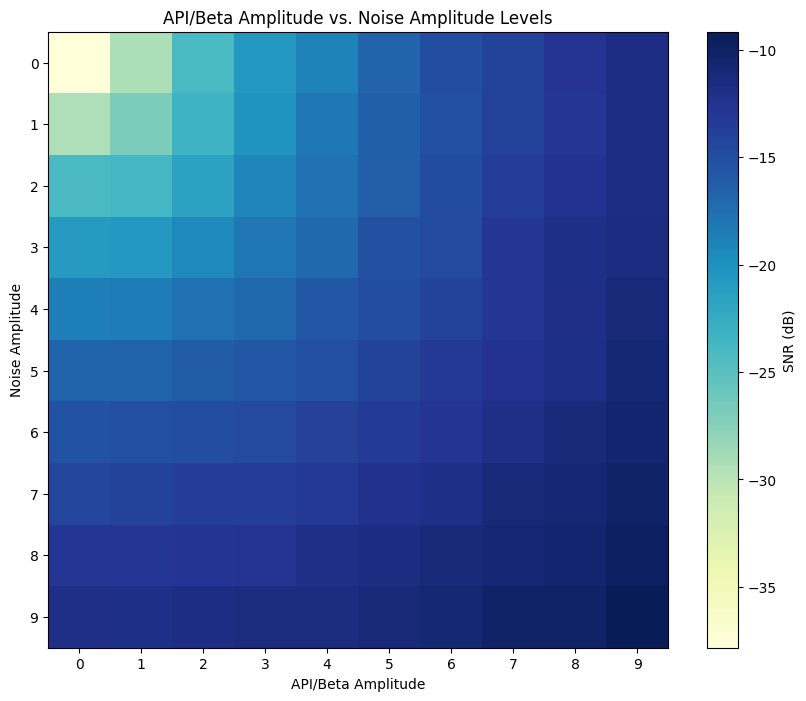

In [10]:
def bandpass_filter(data, lowcut, highcut, fs, order=5):
    sos = signal.butter(order, [lowcut, highcut], btype='band', fs=fs, output='sos')
    return signal.sosfilt(sos, data)
        
# Step 1: Define the grid search parameters
noise_levels = np.arange(0, 10, 1)    # Noise amplitude from 0 to 9
beta_levels = np.arange(0, 10, 1)    # Beta 
grid = [(n, b) for n in noise_levels for b in beta_levels]

snr_results = np.zeros((len(noise_levels), len(beta_levels)))

# Step 2: Grid search to generate synthetic EEG and calculate SNR
for i, noise_amp in enumerate(noise_levels):
    for j, beta_amp in enumerate(beta_levels):
        print(f"\n\n---------------------------\nTest {i},{j} = noise:{noise_amp} beta:{beta_amp}\n")
        
        # Acquire synthetic EEG data with the current noise and beta amplitude
        session_id = hb.acquire_send_raw(
            user_id='8d60e8693a9560ee57e8eba3', 
            date=datetime.today().strftime('%Y-%m-%d %H:%M:%S'), 
            board="SYNTHETIC", 
            extra={
                "eeg_channels": 16,
                "sampling_rate": 250,
                "noise": noise_amp,            # noise amplitude
                "artifacts": 0.0,              # probability of having a movement/blink artifact in the recording
                "beta_amp": beta_amp,          # beta amplitude
                "modulation_type": 'random',
                "power_law_slope": 1.0
            },
            serial_number="", 
            stream_duration=20, 
            buffer_duration=5
        )
        # Retrieve the data for the session
        results = hb.get_data_by_session(user_id='8d60e8693a9560ee57e8eba3', session_id=session_id)
        eeg_data = np.array(results)

        # Step 1: Filter the raw EEG to get the beta band
        beta_signal = bandpass_filter(eeg_data, 13, 30, 250)
        # Step 2: Compute the power of the beta band
        beta_power_actual = np.mean(beta_signal ** 2, axis=1)  # Mean power across channels
        # # Calculate the PSD using Welch's method
        # freqs, psd = signal.welch(beta_signal, fs=250, window='hamming', nperseg=1024)
        # # Create a mask for frequencies within the desired range
        # mask = (freqs >= 12) & (freqs <= 30) # beta
        # # Apply the mask to select frequencies and corresponding PSD values
        # beta_power_actual = psd[:, mask]
    
        # Step 3: API call to compute beta band power
        # parameters for the filtering
        b_notch, a_notch = signal.iirnotch(50., 2.0, 250)
        sos = signal.butter(10, [1, 40], 'bandpass', fs=250, output='sos')
        new_session_id, processed_data = hb.process_session_pipe(
            pipeline='/filtering/beta',
            params={ 
                "filtering": {'a_notch': a_notch.tolist(), 'b_notch': b_notch.tolist(), 'sos': sos.tolist(),},
                "beta":{},
            },
            user_id='8d60e8693a9560ee57e8eba3', 
            existing_session_id = session_id, # <<<<<<<<<<<< the session_id above
            date=datetime.today().strftime('%Y-%m-%d %H:%M:%S'),
            session_type="Quality Assessment Feature Extraction", 
            tags=['beta']
        )
        extracted_beta = np.array(processed_data)
        # Step 4: Get the extracted beta power from API
        beta_power_extracted = np.mean(extracted_beta ** 2, axis=1)        
        # # Calculate the PSD using Welch's method
        # freqs, psd = signal.welch(extracted_beta, fs=250, window='hamming', nperseg=1024)
        # # Create a mask for frequencies within the desired range
        # mask = (freqs >= 12) & (freqs <= 30) # beta
        # # Apply the mask to select frequencies and corresponding PSD values
        # beta_power_extracted = psd[:, mask]
        # Step 5: Compute residuals and noise power
        # residuals = beta_power_actual - beta_power_extracted
        # noise_power = np.mean(residuals ** 2) 
        # Step 6: Compute SNR
        # snr = 10 * np.log10(beta_power_actual / noise_power) # SNR in dB
        # snr = 10 * np.log10(beta_power_actual / beta_power_extracted) # SNR in dB
        snr = 10 * np.log10(beta_power_extracted / beta_power_actual) # SNR in dB
        # Store the SNR result
        snr_results[i, j] = np.mean(snr)

# Step 7: Visualize the results with a heatmap
plt.figure(figsize=(10, 8))
plt.imshow(snr_results, cmap="YlGnBu", aspect='auto')
plt.colorbar(label='SNR (dB)')
plt.xticks(ticks=np.arange(len(beta_levels)), labels=beta_levels)
plt.yticks(ticks=np.arange(len(noise_levels)), labels=noise_levels)
plt.title("API/Beta Amplitude vs. Noise Amplitude Levels")
plt.xlabel("API/Beta Amplitude")
plt.ylabel("Noise Amplitude")
plt.show()

## Evaluation

Now we have a reproducible measure of the range of noise and signal values within which the API is capable of extracting the beta content.

# Next steps
**Different Noise Types**: Instead of just increasing noise amplitude linearly, introduce different types of noise (e.g., white noise, pink noise, bursts of noise) and evaluate how these impact feature extraction.

**Multiple Runs per Condition**: For each combination of noise and feature amplitude, run multiple simulations to account for the stochastic nature of EEG generation and noise. Compute the average and standard deviation of the extracted feature content to get a more reliable assessment.

**Multi-Feature Analysis**: It would be valuable to simultaneously assess other extracted features (e.g., power in other bands, entropy) to see how noise affects the overall feature set.

**Benchmark Against Real Data**: Compare synthetic data with real EEG data under similar noise conditions. This would help ensure that the synthetic data accurately represents real-world scenarios.

**Time-Based Variation**: Instead of just looking at static EEG segments, analyze how the extraction performs over time if noise levels or alpha content change dynamically within the signal.